# Applying Algorithm with MNIST (MLP model)

<font color = "#CC3D3D"><p>
- [Module Import](#Module-Import)
- [Device Checking](#Device-Checking)
- [Data Downloading](#Data-Downloading)
- [Build Model](#Build-Model)
- [Model Train, Test](#Model-Train,-Test)

## Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import transforms, datasets
import torch.nn.init as init
import random 

## Device Checking 

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version: ', torch.__version__, 'DEVICE:', DEVICE)
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(777)

Using PyTorch version:  1.8.0 DEVICE: cuda


## Data Downloading 

#### Hyper parameter

In [3]:
BATCH_SIZE = 32  # MNIST train dataset - 60000, batch_size - 32, batch_num - 1875(60000/32)
EPOCHS = 10
Learning_Rate = 0.01  

In [4]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,   
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False, 
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True) 

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

#### 데이터 확인

In [5]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())  # [Mini-Batch, Channel, Height, Weight]  
    break
# 32개의 이미지가 1개의 Mini-Batch를 구성하고 있고 가로 28개, 세로 28개의 픽셀로 구성돼 있으며 
# 채녈이 1이므로 Gray Scale(흑백이미지)로 이루어진 이미지 데이터

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


#### 실제 MNIST 데이터 확인

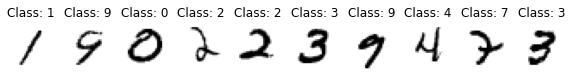

In [6]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")  # [32, 1, 28, 28] -> [28, 28, 1]
    plt.title('Class: ' + str(y_train[i].item()))  # 이미지별로 라벨 할당

## Build_basic_Model 

In [7]:
# 딥러닝 모델 함수를 포함하는 nn.Module 클래스를 상속받는 Net클래스
class Net(nn.Module):
    # Net 클래스의 인스턴스를 생성했을 때 지니게 되는 성질을 정의해주는 메서드
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  # 0부터 9까지 총 10가지 클래스를 표현하기 위한 Label값을 원-핫 인코딩으로 표현
    
    # forward propagation 정의    
    def forward(self, x):  
        x = x.view(-1, 28 * 28)  # MLP 모델은 1차원의 벡터 값을 입력으로 받아야 함
        x = self.fc1(x)
        x = F.sigmoid(x) # 활성화 함수 
    
        x = self.fc2(x)
        x = F.sigmoid(x)
        
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)  # 10가지 경우의 
        return x

In [8]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = Learning_Rate) # 옵티마이저 
criterion = nn.CrossEntropyLoss() # 비용함수 

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


## Model Train, Test 

In [9]:
def train(model, train_loader, optimizer, log_interval):
    model.train()            # train을 하겠다고 선언해준다. 
    train_loss = 0
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        optimizer.zero_grad()
        
        output = model(image)
        loss = criterion(output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))
            
    train_loss /= batch_idx
    return train_loss

In [10]:
def evaluate(model, test_loader):
    model.eval()                      # 평가를 한다고 선언해준다. 
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): 
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

#### 학습, 테스트 진행 

In [11]:
train_loss_item = []
test_loss_item = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    train_loss_item.append(train_loss)
    test_loss_item.append(test_loss)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

C:\Users\leeji\anaconda3\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.366495
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.424147
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.267326
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.201989
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.194285
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.587600
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.292032
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.016331
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.121224
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.194711

[EPOCH: 1], 	Test Loss: 0.0044, 	Test Accuracy: 95.82 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.076636
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.146435
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.071511
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.083422
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.249258
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.112511
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.273832
T

## Build_algorithm_Model 

#### apply - BatchNorm, DropOut, ReLU

In [12]:
class Net_al(nn.Module):
    def __init__(self):
        super(Net_al, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.batch_norm1 = nn.BatchNorm1d(512)                      # batch norm을 사용할 때 size를 맞춰주어야 한다.
        
        self.fc2 = nn.Linear(512, 256)
        self.batch_norm2 = nn.BatchNorm1d(256) 
        
        self.fc3 = nn.Linear(256, 10)
        
        self.dropout_prob = 0.5                                     # 0.5 비율의 node수를 dropout 하여 학습한다.
         
        

    def forward(self, x):
        x = x.view(-1, 28 * 28)                                    # view 함수를 통해 28 * 28 size를 일렬로 펼쳐준다.
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) 
        x = F.dropout(x, training = self.training, p = self.dropout_prob)   # p 값에 dropout_prob가 들어간다.
        
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)    # MNIST data의 차원이 1차원이므로 dim=1로 설정한다.
        return x

In [13]:
## 같은 코드이지만 다른 스타일로 nn.Sequential을 사용하여 짤 수 있다.

drop_prob = 0.5           # drop_prob는 hyper parameter이므로 미리 설정한다.
class Net_al(nn.Module):
    def __init__(self):
        super(Net_al, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p = drop_prob)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p = drop_prob)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(256, 10),
            nn.LogSoftmax(dim = 1)
        )
        
        

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

#### apply - He Initialization, Adam Optimizer

In [14]:
# He initialization
def weight_init(m):
    if isinstance(m, nn.Linear):                          # m이 nn.Linear이라면 실행해줌
        init.kaiming_uniform_(m.weight.data)            # HE initialization을 적용하는 코드

model_al = Net_al().to(DEVICE)
model_al.apply(weight_init)                                                 # apply 함수를 통해 model에 가중치 초기화함수 적용
optimizer = torch.optim.Adam(model_al.parameters(), lr = Learning_Rate)    # 옵티마이저 
criterion = nn.CrossEntropyLoss()                                          # 비용함수 

print(model_al)

Net_al(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


#### 알고리즘이 있는 model 학습, 테스트

In [15]:
train_loss_item_al = []
test_loss_item_al = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model_al, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model_al, test_loader)
    train_loss_item_al.append(train_loss)
    test_loss_item_al.append(test_loss)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.959459
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.824352
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.620122
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.217175
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.401572
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.070856
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.457302
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.359630
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.251777
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.165015

[EPOCH: 1], 	Test Loss: 0.0039, 	Test Accuracy: 96.16 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.123113
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.470857
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.271360
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.115568
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.185269
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.293502
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.073592
T

### 두 model 비교해보기

<font color = "#CC3D3D"><p>
-[basic model 학습 결과](#학습,-테스트-진행) 
    
-[알고리즘을 적용한 model 학습 결과](#알고리즘이-있는-model-학습,-테스트)